## Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ML Helpers/Metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# Algorithms
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

# trees
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

# fun ones
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Reusable Function for ML Experimentation

5-fold cross validation + train/test splits to generate images

Target metrics to minimize are cross validation RMSE + MAE

In [2]:
# Helper Function
def doMLRegression(model, X_train, y_train, X_test, y_test):
    # Set up k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validate the model
    cv_r2 = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')
    cv_mse = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_mse)
    cv_mae = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

    # Print cross-validation metrics
    print("CROSS-VALIDATION METRICS (Training Data)")
    print(f"Mean R2: {np.mean(cv_r2)}")
    print(f"Mean MSE: {np.mean(-cv_mse)}")
    print(f"Mean RMSE: {np.mean(cv_rmse)}")
    print(f"Mean MAE: {np.mean(-cv_mae)}")
    print()
    
    # fit the model
    model.fit(X_train, y_train)

    # predict the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # get the TRAIN metrics
    resids = y_train - train_preds
    r2 = r2_score(y_train, train_preds)
    mse = mean_squared_error(y_train, train_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, train_preds)

    # Print releveant metrics.
    print("TRAINING SET METRICS")
    print(f"The r2 is {r2}.")
    print(f"The mean squared error is {mse}.")
    print(f"The root mean squared error is {rmse}.")
    print(f"The mean absolute error is {mae}.")
    
    # get the TEST metrics
    resids = y_test - test_preds
    r2 = r2_score(y_test, test_preds)
    mse = mean_squared_error(y_test, test_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, test_preds)

    # Print releveant metrics.
    print()
    print("TESTING SET METRICS")
    print(f"The r2 is {r2}.")
    print(f"The mean squared error is {mse}.")
    print(f"The root mean squared error is {rmse}.")
    print(f"The mean absolute error is {mae}.")

    # Predicted vs Actual Graph
    plt.scatter(test_preds, y_test)
    plt.xlabel("Predictions")
    plt.ylabel("Observed")
    plt.title("Predicted vs Actual Plot")
    plt.plot(y_test, y_test)
    plt.show()

    # Residual Graph
    plt.scatter(test_preds, resids)
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")
    plt.title("Residuals Plot")
    plt.plot(test_preds, np.zeros(len(test_preds)))
    plt.show()

## Load data

Exclude 2022 as a holdout set to evaluation model performance

In [3]:
df = pd.read_csv("output/data/ml_soccer_data.csv")
df = df.loc[df.season_name != 2022]
print(df.shape)
df.head()

(2927, 58)


,season_name,player_id,player_name,minutes_played,offensive_goals_added,offensive_goals_added_90,player_age,guaranteed_compensation_1,minutes_played_1,share_team_touches_1,attempted_passes_1,completed_passes_1,total_distance_yds_1,total_vertical_distance_yds_1,xcompleted_passes_1,goals_added_above_avg_Dribbling_1,goals_added_above_avg_Fouling_1,goals_added_above_avg_Interrupting_1,goals_added_above_avg_Passing_1,goals_added_above_avg_Receiving_1,goals_added_above_avg_Shooting_1,guaranteed_compensation_2,minutes_played_2,share_team_touches_2,attempted_passes_2,completed_passes_2,total_distance_yds_2,total_vertical_distance_yds_2,xcompleted_passes_2,goals_added_above_avg_Dribbling_2,goals_added_above_avg_Fouling_2,goals_added_above_avg_Interrupting_2,goals_added_above_avg_Passing_2,goals_added_above_avg_Receiving_2,goals_added_above_avg_Shooting_2,guaranteed_compensation_3,minutes_played_3,share_team_touches_3,attempted_passes_3,completed_passes_3,total_distance_yds_3,total_vertical_distance_yds_3,xcompleted_passes_3,goals_added_above_avg_Dribbling_3,goals_added_above_avg_Fouling_3,goals_added_above_avg_Interrupting_3,goals_added_above_avg_Passing_3,goals_added_above_avg_Receiving_3,goals_added_above_avg_Shooting_3,played_two_years_ago,played_three_years_ago,primary_position_AM,primary_position_CB,primary_position_CM,primary_position_DM,primary_position_FB,primary_position_ST,primary_position_W
0,2014,0Oq60APM6D,Jason Hernandez,1868.0,-1.202600,-0.057941,30.0,208333.0,1817.0,0.064367,513.0,412.0,12260.3289,5384.6294,422.5266,0.1371,0.15161,-1.1739,-0.5978,-0.4063,-0.2050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,False,False
1,2014,0Oq60VgM6D,Jeff Larentowicz,3211.0,0.071294,0.001998,30.0,231000.0,3024.0,0.092425,1217.0,928.0,24863.7753,8774.1994,962.7394,-0.4790,0.26440,-1.1032,0.0300,0.3525,0.1768,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,True,False,False,False,False
2,2014,0Oq67EgQ6D,Matt Besler,2415.0,1.094000,0.040770,26.0,180000.0,2811.0,0.113450,1605.0,1242.0,44430.6794,20073.7718,1242.5560,0.1821,0.25460,-1.8372,1.9678,-0.3481,-0.2049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,True,False,False,False,False,False
3,2014,0Oq67k7Q6D,Tristan Bowen,69.0,-0.016700,-0.021783,22.0,156364.0,1259.0,0.053732,380.0,236.0,6457.6914,728.7155,270.9217,-0.4333,-0.16740,0.2524,0.0546,-0.9820,-0.3422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,False,True,False
4,2014,0Oq67xxQ6D,Brandon Barklage,970.0,0.263000,0.024402,27.0,71428.5,2011.0,0.079036,1063.0,795.0,22768.3239,10058.4741,808.8326,-0.4377,-0.05840,0.6478,0.6542,-0.1870,-0.0851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False,False,True,False,False


# Predict minutes_played

In [4]:
# Create our train/test set
target_cols = ['season_name', 'player_id', 'player_name', 'minutes_played', 'offensive_goals_added', 'offensive_goals_added_90']

X = df.drop(columns=target_cols)
y = df["minutes_played"]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.25,
                                                    random_state=42,)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2195, 52) (2195,)
(732, 52) (732,)


### Model Experimentation

Linear models will use a StandardScaler to normalize the input features

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.30490684056421646
Mean MSE: 672697.3401751007
Mean RMSE: 820.0739756734911
Mean MAE: 673.1154660368499

TRAINING SET METRICS
The r2 is 0.34394988344737865.
The mean squared error is 637054.1280760405.
The root mean squared error is 798.1567064656166.
The mean absolute error is 655.8395551410729.

TESTING SET METRICS
The r2 is 0.29821163548105367.
The mean squared error is 646832.7556691217.
The root mean squared error is 804.259134650718.
The mean absolute error is 655.6871933611466.


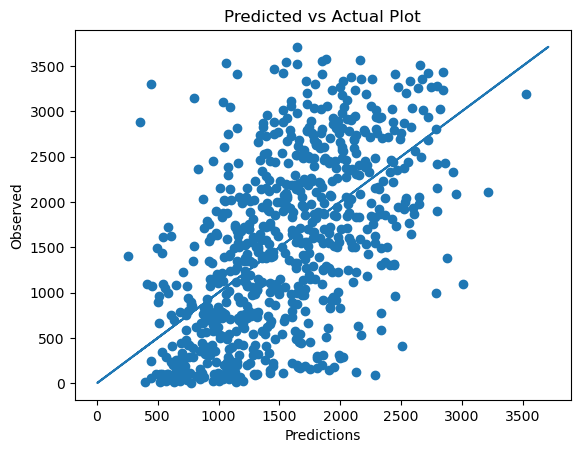

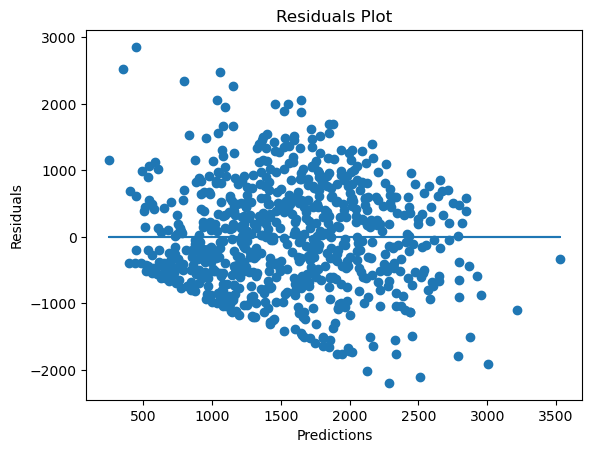

In [5]:
lr = Pipeline([
    ('scaler', StandardScaler()), 
    ('lr', LinearRegression())
])
doMLRegression(lr, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.3060150704287235
Mean MSE: 671631.8680461564
Mean RMSE: 819.4152386436048
Mean MAE: 672.5506618900325

TRAINING SET METRICS
The r2 is 0.34290498390924284.
The mean squared error is 638068.7724567046.
The root mean squared error is 798.7920708524244.
The mean absolute error is 656.182201840223.

TESTING SET METRICS
The r2 is 0.30340414347205213.
The mean squared error is 642046.8623393659.
The root mean squared error is 801.2782677318572.
The mean absolute error is 653.8664925164991.


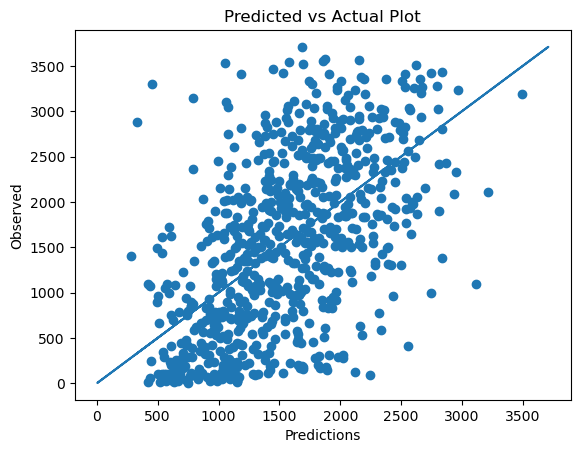

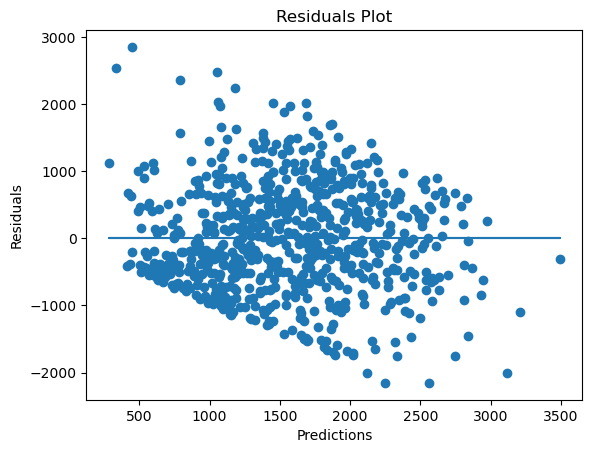

In [6]:
ridge = Pipeline([
    ('scaler', StandardScaler()), 
    ('ridge', Ridge())
])
doMLRegression(ridge, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.29962693032390475
Mean MSE: 678240.2639636192
Mean RMSE: 823.3007627613428
Mean MAE: 686.2646927910907

TRAINING SET METRICS
The r2 is 0.31627864916919524.
The mean squared error is 663924.1393466841.
The root mean squared error is 814.8154020062974.
The mean absolute error is 679.5838529558873.

TESTING SET METRICS
The r2 is 0.29792923154267303.
The mean squared error is 647093.045133738.
The root mean squared error is 804.4209377768196.
The mean absolute error is 664.5214592406319.


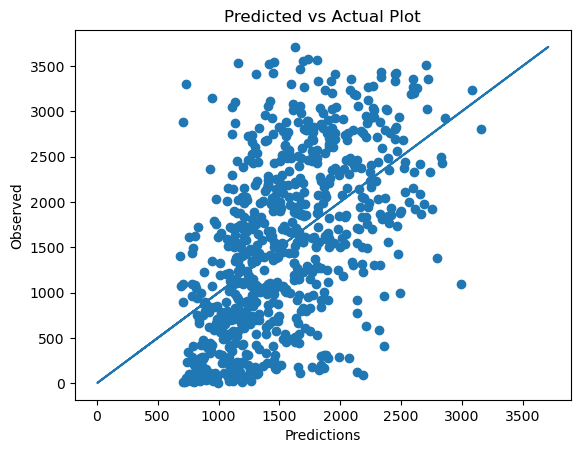

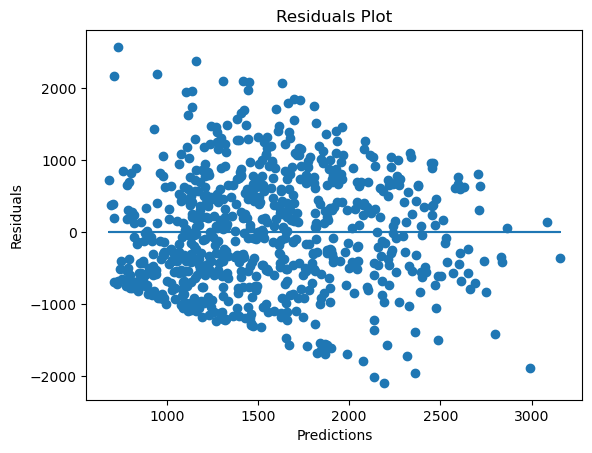

In [7]:
en = Pipeline([
    ('scaler', StandardScaler()), 
    ('en', ElasticNet())
])
doMLRegression(en, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.18146333718535348
Mean MSE: 793346.123106049
Mean RMSE: 890.4423383116833
Mean MAE: 742.6275778283979

TRAINING SET METRICS
The r2 is 0.2921485135250018.
The mean squared error is 687355.5848038471.
The root mean squared error is 829.0691073751616.
The mean absolute error is 688.598967350038.

TESTING SET METRICS
The r2 is 0.17160288232586607.
The mean squared error is 763527.0367880996.
The root mean squared error is 873.8003414900337.
The mean absolute error is 708.2397996357012.


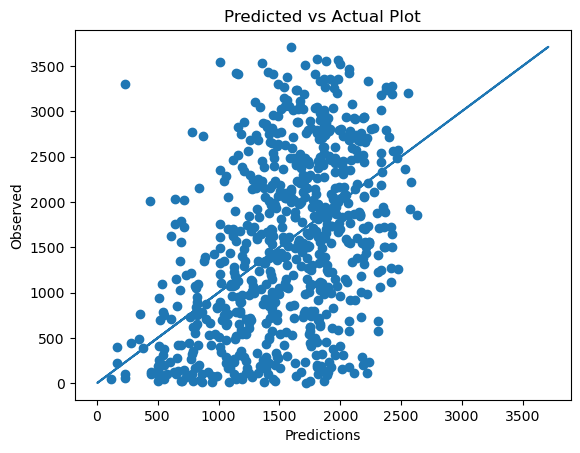

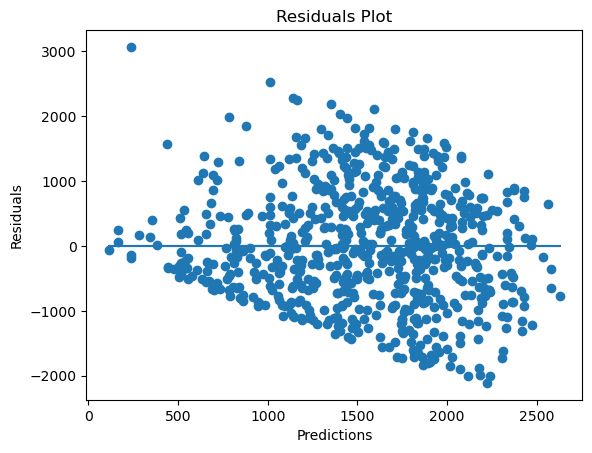

In [8]:
knn = KNeighborsRegressor(n_neighbors=15)
doMLRegression(knn, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.30684788671966545
Mean MSE: 671680.0539190888
Mean RMSE: 819.2589396959702
Mean MAE: 672.6129202733485

TRAINING SET METRICS
The r2 is 0.903324619154354.
The mean squared error is 93876.13674191343.
The root mean squared error is 306.3921290469346.
The mean absolute error is 247.86831435079725.

TESTING SET METRICS
The r2 is 0.32848643069603845.
The mean squared error is 618928.7176338797.
The root mean squared error is 786.7202283111067.
The mean absolute error is 640.0018032786885.


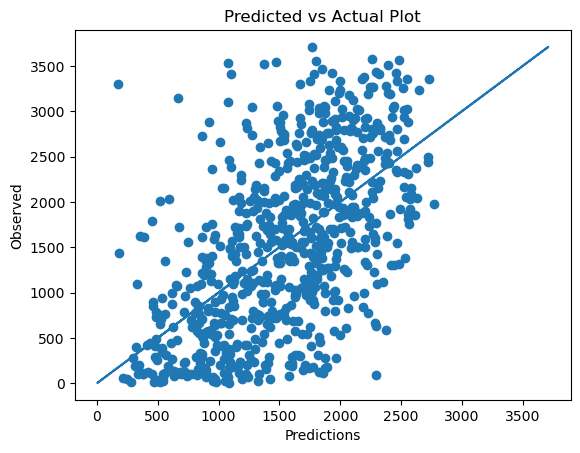

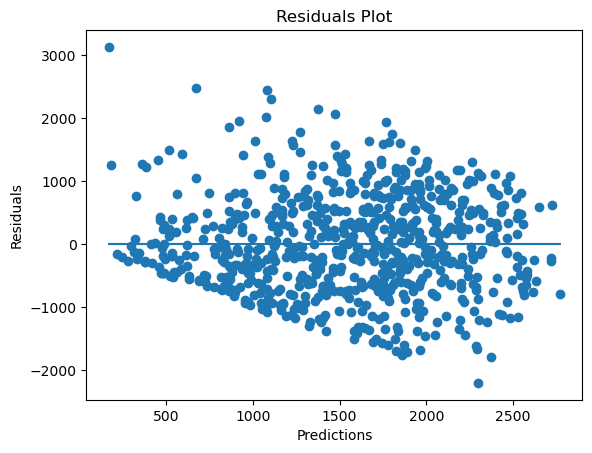

In [9]:
rf = RandomForestRegressor(random_state=42)
doMLRegression(rf, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.26523895451985985
Mean MSE: 711647.9738725884
Mean RMSE: 843.4498147909705
Mean MAE: 711.6436283268572

TRAINING SET METRICS
The r2 is 0.30804479354166714.
The mean squared error is 671919.5829647147.
The root mean squared error is 819.7070104401417.
The mean absolute error is 700.2471856059577.

TESTING SET METRICS
The r2 is 0.2738309795766066.
The mean squared error is 669304.2123660479.
The root mean squared error is 818.1101468421278.
The mean absolute error is 686.5552149205282.


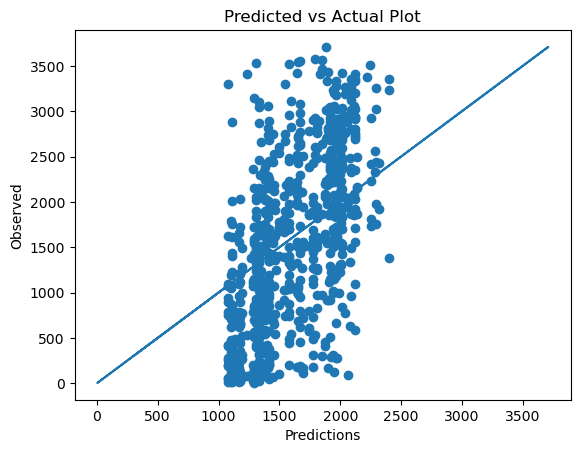

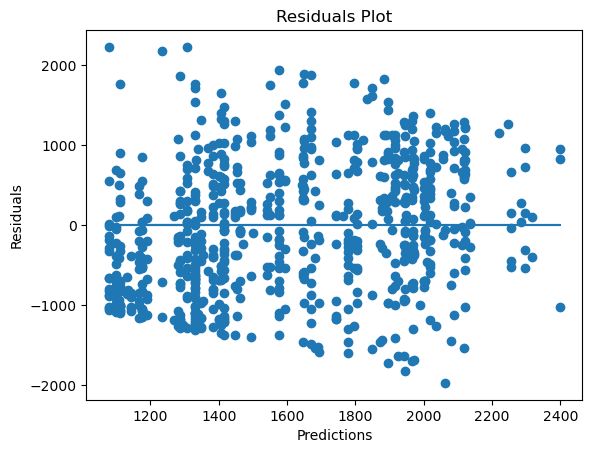

In [10]:
ada = AdaBoostRegressor(random_state=42)
doMLRegression(ada, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.21052298912686984
Mean MSE: 765446.2753893917
Mean RMSE: 874.3820567062032
Mean MAE: 705.4613168280597

TRAINING SET METRICS
The r2 is 0.9819448641625224.
The mean squared error is 17532.34780092627.
The root mean squared error is 132.40977230146675.
The mean absolute error is 91.54674721763455.

TESTING SET METRICS
The r2 is 0.23641212126117683.
The mean squared error is 703792.8765586393.
The root mean squared error is 838.9236416734477.
The mean absolute error is 667.9168337134064.


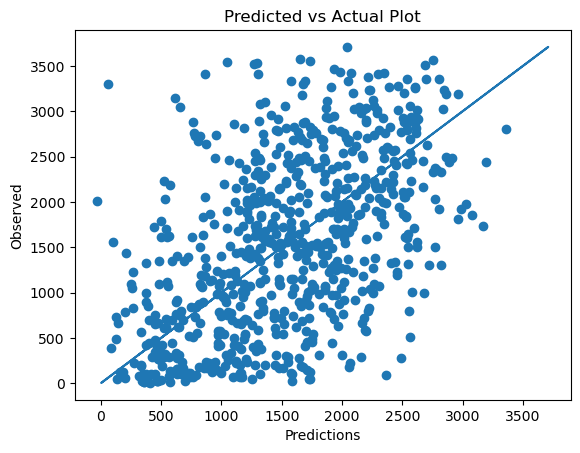

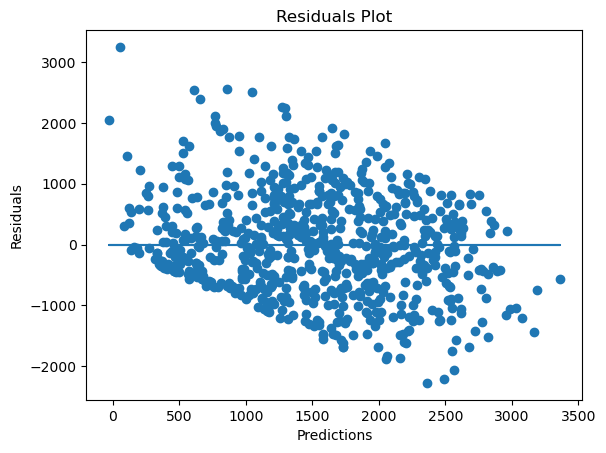

In [11]:
xgb = XGBRegressor(random_state=42)
doMLRegression(xgb, X_train, y_train, X_test, y_test)

CROSS-VALIDATION METRICS (Training Data)
Mean R2: 0.27167387102546225
Mean MSE: 705792.5400085615
Mean RMSE: 839.8273449664812
Mean MAE: 683.7709245857511

TRAINING SET METRICS
The r2 is 0.8524818101431071.
The mean squared error is 143246.7877735692.
The root mean squared error is 378.4795737864452.
The mean absolute error is 296.12849942524906.

TESTING SET METRICS
The r2 is 0.27262911680357105.
The mean squared error is 670411.9597279632.
The root mean squared error is 818.786882972586.
The mean absolute error is 660.0607557194002.


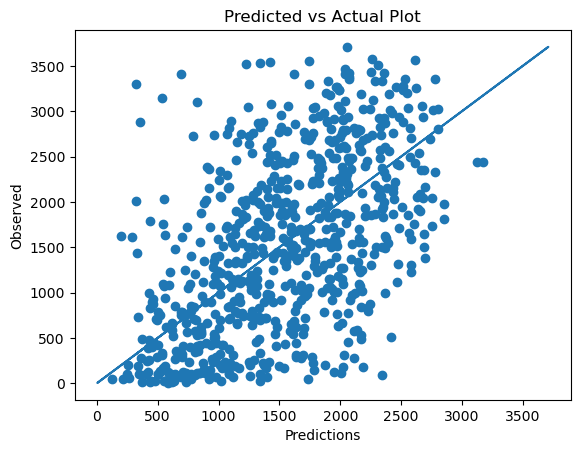

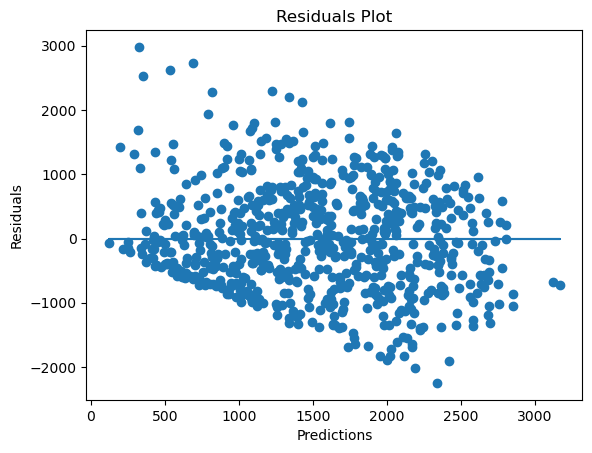

In [12]:
lgb = LGBMRegressor(random_state=42, verbosity=-1)
doMLRegression(lgb, X_train, y_train, X_test, y_test)

In [13]:
fi = pd.DataFrame(list(zip(X.columns, lgb.feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False).head(20)

,Feature,Importance
1,guaranteed_compensation_1,173
3,share_team_touches_1,166
12,goals_added_above_avg_Passing_1,165
14,goals_added_above_avg_Shooting_1,156
11,goals_added_above_avg_Interrupting_1,154
10,goals_added_above_avg_Fouling_1,148
13,goals_added_above_avg_Receiving_1,147
2,minutes_played_1,143
7,total_vertical_distance_yds_1,127
9,goals_added_above_avg_Dribbling_1,126


## Results

Ridge model performs the best in MAE/RMSE. 

Tree and boosted models do not perform as well as the linear models, although LGBM is closer. Metrics are better than OGA_90.

Feature importances seem to make sense - Salary, passing, and touches in the prior year are most important. Teams want to play their well-paid players

## Model Selection

In [14]:
import pickle

# Initialize and train the model on the entire dataset
model = Pipeline([
    ('scaler', StandardScaler()), 
    ('ridge', Ridge())
])
model.fit(X, y)

# Get absolute coefficients
coef_abs = np.abs(model["ridge"].coef_)

# Normalize the coefficients
coef_normalized = coef_abs / np.sum(coef_abs)
fi = pd.DataFrame(list(zip(X.columns, coef_normalized)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False).head(20)

,Feature,Importance
8,xcompleted_passes_1,0.137611
19,completed_passes_2,0.126958
2,minutes_played_1,0.103340
5,completed_passes_1,0.095335
22,xcompleted_passes_2,0.082068
3,share_team_touches_1,0.066676
20,total_distance_yds_2,0.042232
6,total_distance_yds_1,0.035953
15,guaranteed_compensation_2,0.024413
1,guaranteed_compensation_1,0.023399


In [15]:
# Save the model to a file
with open('models/eval/minutes_model_eval.pkl', 'wb') as file:
    pickle.dump(model, file)